# 1a - Hodgkin-Huxel model
In this demo, we will explore the Hodgkin-Huxley (HH) point neuron model. We will set up a class which will allow us to integrate the response of a HH neuron to:
* find the equilibrium values for the neuron state variables;
* find the strength-duration curve of the neuron;
* find the f-I curve of the neuron.

Let's start with the necessary import (you will not need to import anything else to complete the exercise):

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.integrate import odeint

## The `HH_neuron` class
In the following, we define the fundamental class that we will use in this demo.

**Dependencies**

* Part 1 only uses `HH_neuron.compute_derivatives()` and `HH_neuron.integrate()`;
* Part 2 uses `HH_neuron.compute_strength_duration_curve()` (which calls `HH_neuron.compute_derivatives()` and `HH_neuron.integrate()`);
* Part 3 uses `HH_neuron.compute_fI_curve()` (which calls `HH_neuron.compute_derivatives()` and `HH_neuron.integrate()`).

The class has the following methods:
* `HH_neuron.compute_derivatives()`: computes the time derivative of the state variables, according to HH dynamics
$$\begin{aligned}
        &C\dot{V} = I - \bar{g}_{\text{K}}n^{4}(V - E_{\text{K}}) - \bar{g}_{\text{Na}}m^{3}h(V - E_{\text{Na}}) - g_{\text{L}}(V - E_{\text{L}}) \\
        &\dot{n} = \alpha_{n}(V)(1 - n) - \beta_{n}(V)n \\
        &\dot{m} = \alpha_{m}(V)(1 - m) - \beta_{m}(V)m \\
        &\dot{h} = \alpha_{h}(V)(1 - h) - \beta_{h}(V)h
    \end{aligned}$$
where
$$\begin{aligned}
        &\alpha_{n}(V) = 0.01 \cdot \frac{10-V}{\exp\left(\frac{10-V}{10}\right) - 1} \hspace{1 cm} &&\beta_{n}(V) = 0.125\exp\left(\frac{-V}{80}\right) \\
        &\alpha_{m}(V) = 0.1 \cdot \frac{25-V}{\exp\left(\frac{25-V}{10}\right) - 1} &&\beta_{m}(V) = 4\exp\left(-\frac{V}{18}\right) \\
        &\alpha_{h}(V) = 0.07\exp\left(-\frac{V}{20}\right) &&\beta_{h}(V) = \frac{1}{\exp\left(\frac{30-V}{10}\right) + 1}
    \end{aligned}$$
and $E_{\text{K}} = -12 \text{ mV}$, $E_{\text{Na}} = 120 \text{ mV}$, $E_{\text{L}} = 10.6 \text{ mV}$, $\bar{g}_{\text{K}} = 36 \text{ mS/cm}^{2}$, $\bar{g}_{\text{Na}} = 120 \text{ mS/cm}^{2}$, $\bar{g}_{\text{L}} = 0.3 \text{ mS/cm}^{2}$, $C = 1$ $\mu$F/cm$^{2}$.
* `HH_neuron.integrate()`: integrates HH equations using `scipy.integrate.odeint()` and the derivatives computed through `HH_neuron.compute_derivatives()`.

These two methods allow to run any simulation (in our implementation we will apply only pulse and step current stimulation) and thus to build the strength-duration and f-I curves for the neuron.

In [2]:
import scipy.constants as cst

In [3]:
R =cst.R #gas constant [J mol^−1 K^−1]
T = 273.15 + 25 # [kelvin] temperature const

In [4]:
Ah     =     5.796801e-02 
C     =      -4.589622e+02 
D     =      -2.063007e+01
delta_S  =   6.820357e+01
density   =  2.561223e+00 
gamma    =   5.627326e-01 
z1    =      -9.655673e+03 
z2    =    2.365535e+03

Am  =      2.756769e-02 
Vmm  =     7.704963e+01
b1m  =     -2.440201e+01 
b2m  =     4.802552e+01 
c1m  =     -1.712336e-01
c2m  =     4.493341e-02 
d1m  =     4.181831e-03 
d2m  =     4.526902e-03 

#Ts = 0 #no tension
Ts = 0.019122981241363916 #Pressure of -15 mmHg

In [5]:
def BinarySearch(elem, value, max_iter):
        first_elem = 0
        last_elem = len(elem)-1
        idx = -1
        n=0
        while (first_elem <= last_elem) and (idx == -1) and (n<max_iter):
            mid_elem = (first_elem+last_elem)//2
            if elem[mid_elem] == value:
                idx = mid_elem
                
            else:
                if value < elem[mid_elem]:
                    last_elem = mid_elem -1
                else:
                    first_elem = mid_elem +1
            n=n+1
        return idx

def ExponentialSearch(elem, value, max_iter_exp=10, max_iter_bin=100 ):
        if elem[0] == value:
            return 0
        idx = 1
        n=0
        while idx < len(elem) and elem[idx] <= value and n<max_iter_exp:
            idx = idx * 2
            n=n+1

        return BinarySearch(elem[:min(idx, len(elem))], value, max_iter_bin)




class HH_Neuron:
    """
    A classe used to represent and Hodgkin-Huxley point neuron
    
    ...
    
    Attributes
    ----------
    EK : float
        Rest potential for potassium
    ENa : float
        Rest potential for sodium
    EL : float
        Rest potential for leak
    gKbar : float
        Maximum potassium conductance
    gNabar : float
        Maximum sodium conductance
    gL : float
        Leak conductance
    C : float
        Membrane capacity
    x0 : float
        Values of the state variables at rest
    
    Methods
    -------
    compute_derivatives(x, t, delay=None, dur=None, amp=None)
        Compute derivatives to integrate the neuron dynamical system
        
    integrate(t, x0=None, delay=None, amp=None, dur=None)
        Integrate the neuron dynamical system
    
    compute_strength_duration_curve(durs, n_bisec=4)
        Compute the strength-duration curve of the neuron using exponential search
    
    compute_fI_curve()
    """
    
    def __init__(self):
        """
        Sets all biophysics parameters for the model
        """
        # parameters from HH
        self.EK = -12 -70# [mV]  (Task 1)
        self.ENa = 115 -70# [mV]  (Task 1)
        self.EL = 10.6 -70# [mV]  (Task 1)
        self.ETraak = -12 -70

        self.gKbar = 0.75 * 36 # [mS/cm2]  (Task 1)
        self.gTraakbar = 0.25 * 36
        self.gNabar = 120 # [mS/cm2]  (Task 1)
        self.gL = 0.3 # [mS/cm2]  (Task 1)
        self.C = 1 # [uF/cm2]  (Task 1)
        
        self.x0 = np.array([0.32,0.045,0.6,0, 0.14, 0.18]) #  (Task 2)
        
    def compute_derivatives(self, x, t, delay=None, dur=None, amp=None):
        """
        Compute derivatives to integrate the neuron dynamical system
        
        Parameters
        ----------
        x : ndarray
            Values of the state variables
        t : float
            Current time-stamp
        delay : float
            Delay after which intracellular stimulation is turned on
        dur : float
            Duration of intracellular stimulation pulse
        amp : float
            Amplitude of intracellular stimulation pulse
        
        Returns
        -------
        dxdt : ndarray
            Array containing the state variable derivatives
        """
        
        # rename state variables for legibility
        n = x[0]
        m = x[1]
        h = x[2]
        V = x[3]        
        m_mecha = x[4]
        h_mecha = x[5]


        
        alpha_n = 0.01 * (10-(V + 70))/(np.exp((10-(V + 70))/10)-1)  # (Task 1)
        beta_n = 0.125 * np.exp(-(V + 70)/80)   # (Task 1)
        alpha_m = 0.1 * (25-(V + 70))/(np.exp((25-(V + 70))/10)-1)  # (Task 1)
        beta_m = 4 * np.exp(-(V + 70)/18)  # (Task 1)
        alpha_h = 0.07 * np.exp(-(V + 70)/20)  # (Task 1)
        beta_h = 1/(np.exp((30-(V + 70))/10)+1)  # (Task 1)

        # alpham_mecha = Am*np.exp((V-Vmm))
        # betam_mecha = Am*np.exp((V-Vmm)-1)

        # print(alpham_mecha)

        # alphah_mecha = Ah*np.exp(C*cst.N_A*Ts*10**(-20)/(R*T))
        # betah_mecha = Ah*np.exp(D*cst.N_A*Ts*10**(-20)/(R*T))

        alpham_mecha = Am*np.exp(-(b1m*(V-Vmm) + c1m*(V-Vmm)**2 + d1m*(V-Vmm)**3 - gamma*cst.N_A*Ts*delta_S*10**(-20))/(R*T))
        betam_mecha = Am*np.exp(-(b2m*(V-Vmm) + c2m*(V-Vmm)**2 + d2m*(V-Vmm)**3 - (gamma-1)*cst.N_A*Ts*delta_S*10**(-20))/(R*T))

        alphah_mecha = Ah*np.exp(-(z1 - C*cst.N_A*Ts*10**(-20))/(R*T))
        betah_mecha = Ah*np.exp(-(z2 - D*cst.N_A*Ts*10**(-20))/(R*T))
        
        dndt = alpha_n * (1-n) - beta_n * n  # (Task 1)
        dmdt = alpha_m * (1-m) - beta_m * m  # (Task 1)
        dhdt = alpha_h * (1-h) - beta_h * h  # (Task 1)
        dm_mechadt = alpham_mecha * (1-m_mecha) - betam_mecha * m_mecha  # (Task 1)
        dh_mechadt = alphah_mecha * (1-h_mecha) - betah_mecha * h_mecha  # (Task 1)


        if amp is None:
            dVdt = 1 / self.C * (- self.gKbar * n**4 * (V - self.EK) - self.gNabar * m**3 * h * (V - self.ENa) - self.gL * (V - self.EL) - self.gTraakbar * m_mecha * h_mecha * (V - self.ETraak))
        else:
            if t >= delay and t <= delay + dur:
                I = amp
            else:
                I = 0

            dVdt = 1 / self.C * (I - self.gKbar * n**4 * (V - self.EK) - self.gNabar * m**3 * h * (V - self.ENa) - self.gL * (V - self.EL) - self.gTraakbar * m_mecha * h_mecha* (V - self.ETraak))

        dxdt = np.array([dndt, dmdt, dhdt, dVdt, dm_mechadt, dh_mechadt])
        return dxdt


    def integrate(self, t, x0=None, delay=None, dur=None, amp=None):
        """
        Integrate the neuron dynamical system
        
        Parameters
        ----------
        t : float
        x0 : ndarray
        delay : float
        amp : float
        dur : float
        
        Returns
        -------
        sol : ndarray
        """
        
        if x0 is None:
            x0 = self.x0
            
        sol = odeint(self.compute_derivatives, x0, t, args=(delay, dur, amp))
        return sol
    
    def compute_strength_duration_curve(self, durs, n_bisec=4, tstop=100, dt=0.01, n_step_max=10):
        """
        Compute strength-duration curve for the fiber
        
        Parameters
        ----------
        durs : ndarray
            Pulse durations where we sample the strength-duration curve
        n_bisec : int
            Number of bisection steps
        n_step_max : int
            Number of exponential search steps
        
        Returns
        -------
        amp_th : ndarray
            Threshold amplitudes for the specified pulse durations
        """
        nt = int(tstop / dt)
        t = np.linspace(0, tstop, nt)
        n_durs = len(durs)
        amp_th = np.zeros(n_durs)
        delay=0

        for i in range(n_durs):
            # find a value of current for which the neuron fires using exponential search
            # find the threshold value using bisection
            amps = np.linspace(0,1000,200)
            firing=np.zeros(len(amps))
            
            for k in range(len(amps)):
                if (firing[k-1] < 1.):
                    firing[k]=compute_n_spikes(HH_Neuron.integrate(t=t, dur=durs[i], delay=delay, amp=amps[k])[:, 3])
                if (firing[k-1] > 0.):
                    firing[k:]=np.linspace(2,len(amps), len(amps)-k)
                    break
            amp_th[i]=amps[ExponentialSearch(firing, 1., n_step_max, n_bisec)]

        return amp_th
    
    def compute_fI_curve(self, amps, delay, tstop=100, dt=0.01):
        """
        Compute fI curve for the fiber
        
        Parameters
        ----------
        amps : ndarray
            Stimulation amplitudes where the frequency values are computed
        delay : float
            Delay before the onset of stimulation
        tstop : float
            Time of end simulation
        
        Returns
        -------
        freqs : ndarray
            Frequencies for the specified amplitudes
        """
        n_amps = amps.size
        nt = int(tstop / dt)
        t = np.linspace(0, tstop, nt)
        firing=np.zeros(n_amps)
        dur = tstop - delay
        
        freqs = np.zeros(n_amps)
        for i in range(n_amps):
            # compute the membrane potential time course for the different stimulation amplitudes (Task 4)
            # compute the number of spikes and the corresponding frequency (Task 4)
            # Hint: to do a step stimulation just put dur > tstop - delay
            freqs[i]=compute_n_spikes(HH_Neuron.integrate(t=t, dur=dur, delay=delay, amp=amps[i])[:, 3])/dur 
            if (freqs[i] <= 2 * (dur)**(-1)) :
                freqs[i] = 0
            
        return freqs

    
def compute_n_spikes(v):
    """
    Check if a membrane potential track contains spikes.

    Parameters
    ----------
    v : ndarray
        Membrane potential track

    Returns
    -------
    n_spikes : bool
        Activation of the fiber (1 : active, 0 : inactive)
    """
    peaks, properties = signal.find_peaks(x=v, height=20, prominence=50)
    n_spikes = peaks.size
    return n_spikes

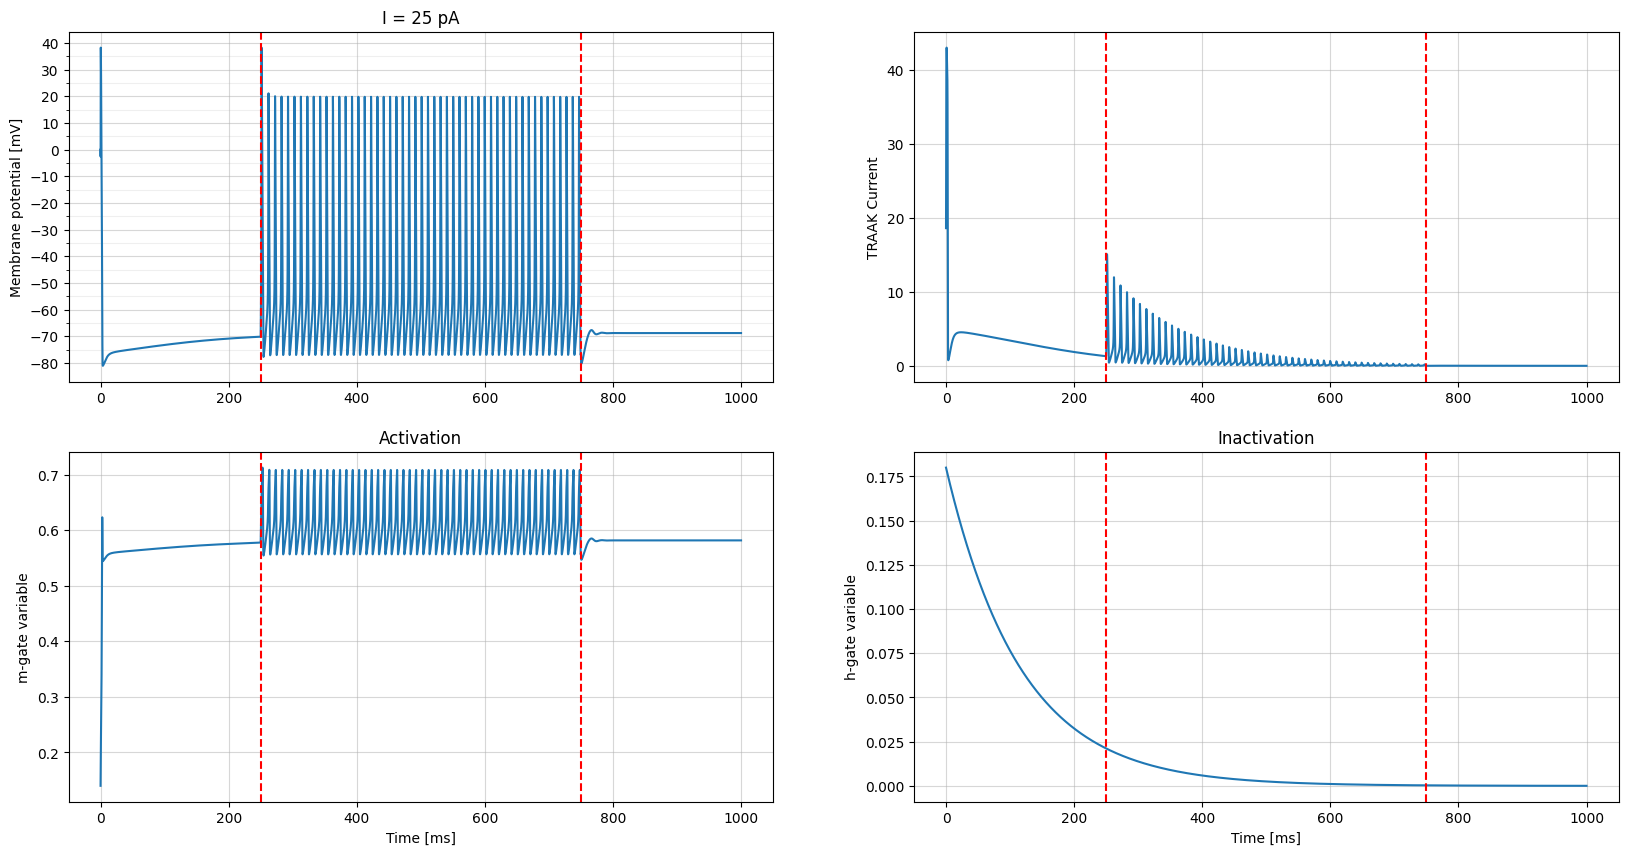

In [6]:
neuron_tension = HH_Neuron()

#STEP 1: PARAMETERS FOR THE VOLTAGE STEPS:
V_amp = -40

tstop = 1000
dt = 0.01
nt = int(tstop / dt)
delay = 250
dur = 500

#STEP 2: ADD TENSION
#Ts = 100

#Define time vector: 
nt = int(tstop / dt)
t = np.linspace(0, tstop, nt)



#sol = neuron_tension.integrate(t=t, delay=delay, dur=dur, V_step=V_amp, Ts_step=Ts)
sol = neuron_tension.integrate(t=t, delay=delay, dur=dur, amp = 25)
#sol = neuron_tension.integrate(t=t, delay=delay, dur=dur, V_step=V_amp)

v = sol[:,3]
I = 0.25 *36  * sol[:,4] * sol[:,5] * (v - (-82))

fig, ax = plt.subplots(2,2, figsize=(20, 10))
major_ticks = np.arange(-80, 120, 10)
minor_ticks = np.arange(-80, 120, 5)
ax[0][0].set_yticks(major_ticks)
ax[0][0].set_yticks(minor_ticks, minor=True)
ax[0][0].grid(which='minor', alpha=0.2)
ax[0][0].grid(which='major', alpha=0.5)
ax[0][0].plot(np.arange(nt)*dt, v)
ax[0][0].axvline(x=delay, c='red', linestyle='--')
ax[0][0].axvline(x=(delay + dur), c='red', linestyle='--')
ax[0][0].set_ylabel('Membrane potential [mV]')
ax[0][0].title.set_text('I = 25 pA')

ax[0][1].plot(np.arange(nt)*dt, I)
ax[0][1].axvline(x=delay, c='red', linestyle='--')
ax[0][1].axvline(x=(delay + dur), c='red', linestyle='--')
ax[0][1].grid(which='minor', alpha=0.2)
ax[0][1].grid(which='major', alpha=0.5)
ax[0][1].set_ylabel('TRAAK Current')

ax[1][0].plot(np.arange(nt)*dt, sol[:,4])
ax[1][0].axvline(x=delay, c='red', linestyle='--')
ax[1][0].axvline(x=(delay + dur), c='red', linestyle='--')
ax[1][0].set_xlabel('Time [ms]')
ax[1][0].grid(which='minor', alpha=0.2)
ax[1][0].grid(which='major', alpha=0.5)
ax[1][0].set_ylabel('m-gate variable')
ax[1][0].title.set_text('Activation')


ax[1][1].plot(np.arange(nt)*dt, sol[:,5])
ax[1][1].axvline(x=delay, c='red', linestyle='--')
ax[1][1].axvline(x=(delay + dur), c='red', linestyle='--')
ax[1][1].set_xlabel('Time [ms]')
ax[1][1].set_ylabel('h-gate variable')
ax[1][1].grid(which='minor', alpha=0.2)
ax[1][1].grid(which='major', alpha=0.5)
ax[1][1].title.set_text('Inactivation')

